# Submission 3: Denoising Autoencoder

## Introduction 
This DAE machine learning architecture is inspired by the first place solution in Tabular Playground January by Danzel [1st place - turn your data into DAEta](https://www.kaggle.com/springmanndaniel/1st-place-turn-your-data-into-daeta/report). It is speculated that this works well since the data itself is artificially created with noise using CTGAN. 

In [111]:
# fundamentals
import six
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import numpy as np
import scipy
import math

# data exploration 
from pandas_profiling import ProfileReport
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True, world_readable=True)
from plotly.offline import iplot

# data preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# hyperparameter tuning 
import kerastuner as kt


# metrics for evaluation
from sklearn.metrics import mean_squared_error
from scipy import stats

# saving parameters
from joblib import dump, load

# hyperparameter searching and tuning 
import optuna
import tqdm

In [2]:
#fixing random seed for reproducability
import random

random.seed(0)
np.random.seed(0)

In [3]:
original_df = pd.read_csv('train.csv', index_col = 'id')

In [4]:
test = pd.read_csv('test.csv', index_col = 'id')

In [5]:
categorical_col = ['cat0','cat1','cat2','cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']

In [6]:
X_train = original_df.drop(columns = 'target', axis =1)
Y_train = original_df['target']
X_train

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,B,D,A,E,C,I,...,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903
2,B,A,A,A,B,B,A,E,A,F,...,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464
3,A,A,A,C,B,D,A,B,C,N,...,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352
4,A,A,A,C,B,D,A,E,G,K,...,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766
6,A,B,A,A,B,B,A,E,C,F,...,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,A,B,A,C,B,B,A,E,E,L,...,0.768447,0.269578,0.258655,0.363598,0.300619,0.340516,0.235711,0.383477,0.215227,0.793630
499996,A,B,A,C,B,B,A,E,E,L,...,0.775951,0.197211,0.257024,0.574304,0.227035,0.322583,0.286094,0.324874,0.306933,0.230902
499997,A,B,A,C,B,B,A,E,C,M,...,0.297406,0.449482,0.386172,0.476217,0.135947,0.502730,0.235788,0.316671,0.250286,0.349041


In [7]:
input_data = pd.concat([X_train, test], axis = 0)
input_data.shape

(500000, 24)

In [8]:
enc = OneHotEncoder(handle_unknown='error')
# passing max 4 cardinality category column (label encoded values of bridge_types)

In [9]:
enc.fit(X_train[['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5']])
enc_df = pd.DataFrame(enc.transform(X_train[['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5']]).toarray())
enc_df.index = X_train.index
# merge with main df with encoded df on key values
X_train = pd.concat([X_train, enc_df], ignore_index = False, axis = 1)

In [10]:
enc_df = pd.DataFrame(enc.transform(test[['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5']]).toarray())
enc_df.index = test.index
# merge with main df with encoded df on key values
test = pd.concat([test, enc_df], ignore_index = False, axis = 1)

In [11]:
enc_df = pd.DataFrame(enc.transform(input_data[['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5']]).toarray())
enc_df.index = input_data.index
# merge with main df with encoded df on key values
input_data = pd.concat([input_data, enc_df], ignore_index = False, axis = 1)

In [12]:
input_data

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,8,9,10,11,12,13,14,15,16,17
id,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,B,D,A,E,C,I,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,B,A,A,A,B,B,A,E,A,F,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,A,A,A,C,B,D,A,B,C,N,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,A,A,A,C,B,D,A,E,G,K,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,A,B,A,A,B,B,A,E,C,F,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499987,A,A,A,C,B,D,A,E,G,L,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
499990,A,A,A,C,B,D,A,E,E,F,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
499991,A,A,A,C,B,D,A,E,C,K,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
for df in [X_train, test, input_data]:
    df.drop(columns = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5'], inplace = True)
input_data

,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,...,8,9,10,11,12,13,14,15,16,17
id,,,,,,,,,,,,,,,,,,,,,
1,A,E,C,I,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,A,E,A,F,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,A,B,C,N,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,A,E,G,K,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,A,E,C,F,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499987,A,E,G,L,0.919265,0.111147,0.199583,0.181354,0.277365,0.963678,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
499990,A,E,E,F,0.362875,-0.020197,0.469025,0.336185,0.523174,0.232072,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
499991,A,E,C,K,0.463060,0.740421,0.446293,0.411387,0.517103,0.432927,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
le = OrdinalEncoder()
le.fit(X_train[['cat6', 'cat7', 'cat8','cat9']])
X_train[['cat6', 'cat7', 'cat8','cat9']] = le.transform(X_train[['cat6', 'cat7', 'cat8','cat9']])
test[['cat6', 'cat7', 'cat8','cat9']] = le.transform(test[['cat6', 'cat7', 'cat8','cat9']])
input_data[['cat6', 'cat7', 'cat8','cat9']] = le.transform(input_data[['cat6', 'cat7', 'cat8','cat9']])

In [15]:
input_data

,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,...,8,9,10,11,12,13,14,15,16,17
id,,,,,,,,,,,,,,,,,,,,,
1,0.0,4.0,2.0,8.0,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,4.0,0.0,5.0,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,2.0,13.0,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,4.0,6.0,10.0,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,4.0,2.0,5.0,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499987,0.0,4.0,6.0,11.0,0.919265,0.111147,0.199583,0.181354,0.277365,0.963678,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
499990,0.0,4.0,4.0,5.0,0.362875,-0.020197,0.469025,0.336185,0.523174,0.232072,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
499991,0.0,4.0,2.0,10.0,0.463060,0.740421,0.446293,0.411387,0.517103,0.432927,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
X_columns = len(input_data.columns)

In [17]:
# minmax scaling
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
test = scaler.transform(test)
input_data = scaler.transform(input_data)

In [18]:
def inputSwapNoiseTEST(arr, p, randomise_type = 'random'):
    '''
    Takes a numpy array and swaps a row of each 
    feature with another value from the same column with probability p
    '''

    n, m = arr.shape #row, col
    idx = range(n)
    swap_n = round(n*p)
    arr2 = arr.copy()

    if randomise_type == 'random':
        for i in range(m):
            col_vals = np.random.permutation(arr[:, i]) 
            swap_idx = np.random.choice(idx, size= swap_n) 
            arr2[swap_idx, i] = np.random.choice(col_vals, size = swap_n) # n*p row and change it 
            
    elif randomise_type == 'row':
        row_ref = np.random.permutation(n) # change the order of the row
        for i in range(n):
            
            arr2[i,:] = np.random.choice(col_vals, size = swap_n) # n*p row and change it 
            
    return arr2

In [19]:
matrix = np.arange(1,31).reshape(6,5)
matrix

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25],
       [26, 27, 28, 29, 30]])

In [20]:
matrix2 =  inputSwapNoiseTEST(matrix, p = 0.2, randomise_type = 'random')
matrix2

array([[ 1,  2,  3, 14,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 25],
       [21, 22, 23, 24, 25],
       [ 6, 27, 28, 29, 30]])

In [18]:
input_data.shape

(500000, 36)

In [134]:
class KFoldAverageDAE:
    def __init__(self, FOLDS):
        # creating CV folds for training 
        self.models = []
        self.kfolds = KFold(n_splits = FOLDS, 
                            shuffle = True,
                            random_state = 50)
        
        
    def get_autoencoder_model(self, train_x):
        """
        transform the 1 row of 36 features (1 * 36) into (3 * 800) layers autoencoder
        
        """
        len_input_output = train_x.shape[-1]
        self.input_ = keras.Input((len_input_output,), name = 'original_data')
        self.encode1 = Dense(units = 1024, activation='swish')(self.input_)
        self.encode2 = Dense(units = 512, activation='swish')(self.encode1)
        self.bottleneck = Dense(units=64, activation='linear')(self.encode2)
        
        # Use only the encoder part for denoising 
        self.encoder = keras.Model(inputs= self.input_, outputs= (self.bottleneck), name = "encoder")   
        self.encoder.summary()
        
        
        self.decoder_input = keras.Input(shape = (64,), name = 'encoded_data')
        self.decoder1 = Dense(units = 512, activation='swish')(self.decoder_input)
        self.decoder2 = Dense(units = 1024, activation='swish')(self.decoder1)
        self.decoder_output = Dense(units = len_input_output, activation = 'linear')(self.decoder2)
        self.decoder = keras.Model(self.decoder_input, self.decoder_output, name = "decoders")
        self.decoder.summary()
        
        # Training is performed on the entire autoencoder
        
        self.autoencoder_input = keras.Input((len_input_output,), name = 'data')
        self.encoded_data = self.encoder(self.autoencoder_input)
        self.decoded_data = self.decoder(self.encoded_data)
        self.autoencoder = keras.Model(inputs = self.autoencoder_input, 
                                       outputs= self.decoded_data,
                                      name = "autoencoder")
        
        
        self.autoencoder.summary()
        
        self.autoencoder.compile(optimizer = Adam(learning_rate = 0.1), loss = 'mse', metrics = 'mse')
        
        model = self
        return model
    
    
    def inputSwapNoise(self, arr, p, randomise_type = 'random'):
        '''
        Takes a numpy array and swaps a row of each 
        feature with another value from the same column with probability p
        '''

        n, m = arr.shape
        idx = range(n)
        swap_n = round(n*p)
        arr2 = arr.copy()
        for i in range(m):
            col_vals = np.random.permutation(arr[:, i]) # change the order of the row
            swap_idx = np.random.choice(idx, size= swap_n) # choose row
            arr2[swap_idx, i] = np.random.choice(col_vals, size = swap_n) # n*p row and change it 
        return arr2
        
    def autoencoder_fit(self, INPUT_DATA, BATCH_SIZE, EPOCHS, p, randomise_type = 'random'):
        
        noised_data = self.inputSwapNoise(INPUT_DATA, p)

        oof_preds = np.zeros_like(INPUT_DATA)
        self.noised_data = pd.DataFrame(noised_data).values
        self.INPUT_DATA = pd.DataFrame(INPUT_DATA).values
        
        
        # adding callbacks
        model_save = ModelCheckpoint('./best_DAE_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 10)
        early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0005, 
                           patience = 10, mode = 'min', verbose = 10,
                           restore_best_weights = True)
        reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                              patience = 5, min_delta = 0.0005, 
                              mode = 'min', verbose = 10)
        
        
        for train_idx, val_idx in self.kfolds.split(INPUT_DATA):
            noised_data_train_CV, noised_data_val_CV = self.noised_data[train_idx], self.noised_data[val_idx]
            INPUT_DATA_train_CV, INPUT_DATA_val_CV = self.INPUT_DATA[train_idx], self.INPUT_DATA[val_idx]
            
                
            model.autoencoder.fit(x = noised_data_train_CV, 
                                      y = INPUT_DATA_train_CV, 
                                      batch_size = BATCH_SIZE,
                                      validation_data = (noised_data_val_CV,INPUT_DATA_val_CV),
                                      epochs = EPOCHS, 
                                      callbacks = [model_save, early_stop, reduce_lr])
            
            
            self.models.append(model)
            oof_pred = self.autoencoder.predict(noised_data_val_CV)
            oof_preds[val_idx] = oof_pred

        self.oof_preds = oof_preds
        
        self.rmse = mean_squared_error(INPUT_DATA, oof_preds, squared = False)
        
    def encoder_predict(self, test_x):
        preds = []
        for model in tqdm.tqdm(self.models):
            pred = model.encoder.predict(test_x)
            preds.append(pred)
        preds = np.mean(preds, axis=0)
        return preds
    

In [135]:
X_train

array([[0.        , 0.57142857, 0.33333333, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.57142857, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.14285714, 0.33333333, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.57142857, 0.33333333, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.42857143, 0.66666667, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.57142857, 0.33333333, ..., 0.        , 0.        ,
        1.        ]])

In [136]:
model = KFoldAverageDAE(FOLDS = 5)

In [137]:
model = model.get_autoencoder_model(input_data)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_data (InputLayer)   [(None, 36)]              0         
_________________________________________________________________
dense_51 (Dense)             (None, 1024)              37888     
_________________________________________________________________
dense_52 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_53 (Dense)             (None, 64)                32832     
Total params: 595,520
Trainable params: 595,520
Non-trainable params: 0
_________________________________________________________________
Model: "decoders"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_data (InputLayer)    [(None, 64)]              0         
___________________________________

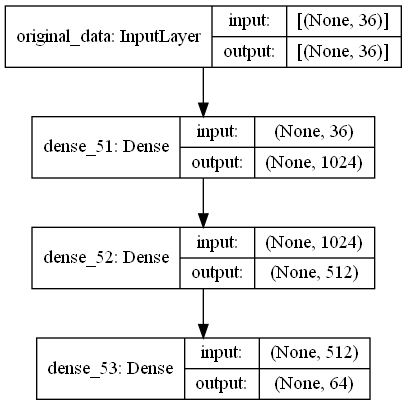

In [138]:
keras.utils.plot_model(model.encoder, "encoder.png", show_shapes=True, show_layer_names = True)

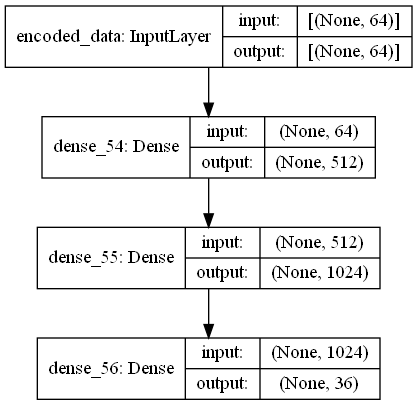

In [139]:
keras.utils.plot_model(model.decoder, "decoder.png", show_shapes=True, show_layer_names = True)

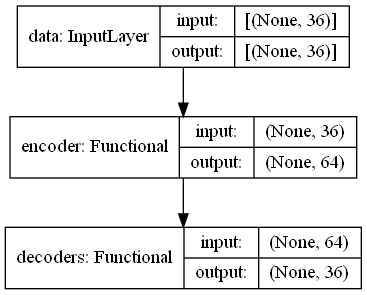

In [140]:
keras.utils.plot_model(model.autoencoder, "DAE.png", show_shapes=True, show_layer_names = True)

In [141]:
model.autoencoder_fit(input_data, 
                      BATCH_SIZE = 64, 
                      EPOCHS = 1000,
                      p = 0.4)

Epoch 1/1000
6250/6250 [==============================] - 29s 5ms/step - loss: 329349341248.9799 - mse: 329349341248.9799 - val_loss: 0.1473 - val_mse: 0.1473

Epoch 00001: val_loss improved from inf to 0.14727, saving model to .\best_DAE_model.h5
Epoch 2/1000
6250/6250 [==============================] - 28s 5ms/step - loss: 0.1450 - mse: 0.1450 - val_loss: 0.1242 - val_mse: 0.1242

Epoch 00002: val_loss improved from 0.14727 to 0.12425, saving model to .\best_DAE_model.h5
Epoch 3/1000
6250/6250 [==============================] - 29s 5ms/step - loss: 0.1066 - mse: 0.1066 - val_loss: 0.0755 - val_mse: 0.0755

Epoch 00003: val_loss improved from 0.12425 to 0.07549, saving model to .\best_DAE_model.h5
Epoch 4/1000
6250/6250 [==============================] - 28s 4ms/step - loss: 0.0756 - mse: 0.0756 - val_loss: 0.0755 - val_mse: 0.0755

Epoch 00004: val_loss did not improve from 0.07549
Epoch 5/1000
6250/6250 [==============================] - 30s 5ms/step - loss: 0.0757 - mse: 0.0757 - v


Epoch 00004: val_loss did not improve from 0.07549
Epoch 5/1000
6250/6250 [==============================] - 25s 4ms/step - loss: 0.0756 - mse: 0.0756 - val_loss: 0.0757 - val_mse: 0.0757

Epoch 00005: val_loss did not improve from 0.07549
Epoch 6/1000
6250/6250 [==============================] - 25s 4ms/step - loss: 0.0756 - mse: 0.0756 - val_loss: 0.0757 - val_mse: 0.0757

Epoch 00006: val_loss did not improve from 0.07549

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999998695775504e-09.
Epoch 7/1000
6250/6250 [==============================] - 25s 4ms/step - loss: 0.0756 - mse: 0.0756 - val_loss: 0.0757 - val_mse: 0.0757

Epoch 00007: val_loss did not improve from 0.07549
Epoch 8/1000
6250/6250 [==============================] - 25s 4ms/step - loss: 0.0756 - mse: 0.0756 - val_loss: 0.0757 - val_mse: 0.0757

Epoch 00008: val_loss did not improve from 0.07549
Epoch 9/1000
6250/6250 [==============================] - 25s 4ms/step - loss: 0.0756 - mse: 0.0756 - val_loss:

### model.rmse

In [69]:
import joblib

In [142]:
encoded_X_train = model.encoder_predict(X_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.93s/it]


In [143]:
X_train[0]

array([0.        , 0.57142857, 0.33333333, 0.57142857, 0.88703657,
       0.8160911 , 0.17136704, 0.09536034, 0.11456403, 0.85569127,
       0.35993147, 0.64349616, 0.88282901, 0.81132239, 0.68524143,
       0.65485395, 0.91338699, 0.78520634, 1.        , 0.        ,
       0.        , 1.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        ])

In [151]:
encoded_X_train[1]

array([  391.07187 ,  1434.0673  ,  -764.60156 ,   155.41956 ,
         364.7265  ,   902.9403  ,   640.0755  ,  -108.6369  ,
       -1329.6902  , -1305.2806  , -1278.6647  ,    98.203896,
        -193.96558 ,   294.35324 , -1601.0829  ,  2601.542   ,
        1705.7312  ,  -167.5933  , -1770.8093  ,   792.3981  ,
        -234.64929 , -1090.4094  ,  1466.0442  ,  2672.2476  ,
         696.6223  ,  1584.5569  ,   924.41144 ,  2004.0944  ,
        -876.7328  ,  -232.90364 ,   466.19257 ,  1232.441   ,
        -135.53796 , -2034.4417  ,  2746.304   , -1130.4816  ,
         311.1975  , -1109.4451  ,   232.1073  ,  -584.5104  ,
        1752.1752  ,  1333.5214  , -1342.1704  ,   216.02583 ,
       -2024.3635  ,  1692.3096  ,   -16.456614, -1321.4747  ,
         476.2022  , -1121.1282  ,  3102.898   ,   186.41667 ,
        1581.026   ,  -224.80283 , -2918.3257  ,   -77.200645,
         625.3376  , -2618.1616  ,  2240.9702  ,  1576.1901  ,
         753.0226  , -1727.0164  , -1729.0023  , -1427.

In [152]:
joblib.dump(encoded_X_train, "encoded_X_train.joblib")

['encoded_X_train.joblib']

In [153]:
encoded_X_test = model.encoder_predict(test)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.80s/it]


In [154]:
joblib.dump(encoded_X_test, "encoded_X_test.joblib")

['encoded_X_test.joblib']

In [122]:
encoded_X_train[0][0]

array([0.12009786, 0.12640166, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.44631195, 0.        , 0.        ,
       0.        , 0.        , 0.21731094, 0.4441418 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.1147465 ,
       0.27347428, 0.        , 0.        , 0.36857966, 0.        ,
       0.05280513, 0.36706027, 0.        , 0.37698156, 0.        ,
       0.        , 0.        , 0.08929306, 0.1660731 , 0.        ,
       0.        , 0.15715303, 0.3208198 , 0.        , 0.        ,
       0.1448954 , 0.20213398, 0.5857546 , 0.14967312, 0.        ,
       0.22405055, 0.        , 0.34649685, 0.5353485 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.48480624, 0.17144634, 0.23440376,
       0.2678754 , 0.5993608 , 0.        , 0.01253927, 0.22427464,
       0.        , 0.1107884 , 0.        , 0.        , 0.29521

In [32]:
encoded_X_train[0].shape

(300000, 500)

### Optuna 

In [33]:
np.zeros_like(Y_train).shape

(300000,)

In [46]:
class KFoldsAverageMLP():
    def __init__(self, FOLDS):
        self.models = []
        self.kfolds = KFold(n_splits = FOLDS, shuffle = False)
        
    def fit(self, trial, train_x, train_y, prune = True):
        oof_preds = np.zeros_like(train_y)
        self.train_x = train_x
        self.train_y = train_y.values

        
        
        # adding callbacks
        model_save = ModelCheckpoint('./best_MLP_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 10)
        early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 10,
                           restore_best_weights = True)
        reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                              patience = 3, min_delta = 0.001, 
                              mode = 'min', verbose = 10)
        
        ###############################################################
        stack_num, num_data, encoded_features = self.train_x.shape
        
        # tunable hyperparameters
        input_dense = int(trial.suggest_loguniform('input_dense_layer', 16, 1024))
        input_dropout = trial.suggest_loguniform('input_dropout', 1e-10, 1)
        num_layers =  trial.suggest_int('num_layers', 10, 40)
        learning_rate = trial.suggest_categorical('learning_rate', [0.999, 1e-1, 5e-2, 1e-2, 1e-3])
        
        combined_dense = int(trial.suggest_loguniform('combined_dense_layer', 16, 1024))
        combined_dropout = trial.suggest_loguniform('combined_dropout', 1e-10, 1)
                    
        # the 3 deepstack layers would go through a mini-model before concat to combined NN
        input_a = keras.Input(shape = (encoded_features,), name = 'deepstack layer 1 input')
        x = Dense(input_dense, activation = 'relu')(input_a)
        x = Dropout(input_dropout)(x)
        model_a = keras.Model(input_a, x, name = 'stack_1')
        
        input_b = keras.Input(shape = (encoded_features,), name = 'deepstack layer 2 input')
        y = Dense(input_dense, activation = 'relu')(input_b)
        y = Dropout(input_dropout)(y)
        model_b = keras.Model(input_b,  y, name = 'stack_2')
        
        
        input_c = keras.Input(shape = (encoded_features,), name = 'deepstack layer 3 input')
        z = Dense(input_dense, activation = 'relu')(input_c)
        z = Dropout(input_dropout)(z)
        model_c = keras.Model(input_c,  z, name = 'stack_3')
        
        # the output from the three mini models 
        merged = keras.layers.Concatenate(axis=1)([x, y, z])
        combined = Dense(combined_dense, activation = 'relu', name = 'combining_dense')(merged)
        piped_data = Dropout(combined_dropout)(combined)
        
        for i in range(num_layers):
            num_hidden = int(trial.suggest_loguniform(f'n_units_l{i}', 32, 1024))
            dropout_rate = trial.suggest_loguniform(f'dropout_rate{i}', 1e-10, 1)
            piped_data = Dense(num_hidden, activation='relu')(piped_data)
            piped_data = Dropout(rate=dropout_rate)(piped_data)

        output = Dense(units=1, activation = 'linear')(piped_data)
        MLP = keras.Model([input_a, input_b, input_c], output)
        
        # Tune the learning rate for the optimizer 
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        MLP.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'mse', metrics=[keras.metrics.RootMeanSquaredError()])
    
        
        for train_idx, val_idx in self.kfolds.split(train_x[0]):
            
            
            # spliting the three deepstack layers into different input models before combining 
            X_train_CV0, X_val_CV0 = self.train_x[0][train_idx], self.train_x[0][val_idx]
            X_train_CV1, X_val_CV1 = self.train_x[1][train_idx], self.train_x[1][val_idx]
            X_train_CV2, X_val_CV2 = self.train_x[2][train_idx], self.train_x[2][val_idx]
            
            Y_train_CV, Y_val_CV = self.train_y[train_idx], self.train_y[val_idx]
            
            MLP.fit(x = [X_train_CV0, X_train_CV1, X_train_CV2], 
                      y = Y_train_CV, 
                      epochs = 1000,
                      verbose = 1, 
                      validation_data = ([X_val_CV0, X_val_CV1, X_val_CV2] , Y_val_CV),
                      callbacks = [early_stop,
                                    reduce_lr])       
        
            self.models.append(MLP)
            oof_pred = MLP.predict([X_val_CV0, X_val_CV1, X_val_CV2])
            oof_preds[val_idx] = oof_pred[0]
            
        self.oof_preds = oof_preds
        
        self.rmse = mean_squared_error(Y_train, oof_preds, squared = False)

    def predict(self, test_x):
        preds = []
        for model in tqdm.tqdm(self.models):
            pred = model.predict(test_x)
            preds.append(pred)
        preds = np.mean(preds, axis=0)
        return preds

In [47]:
def objective_keras(trial):   
    optuna_MLP = KFoldsAverageMLP(FOLDS = 5)
    optuna_MLP.fit(trial = trial, train_x = encoded_X_train, train_y = Y_train, prune = True)
    return optuna_MLP.rmse

In [48]:
mlp_study = optuna.create_study(direction="minimize", pruner = optuna.pruners.HyperbandPruner())
mlp_study.optimize(objective_keras, n_trials=50)
print(cb_study.best_trial)

[I 2021-02-18 21:37:20,412] A new study created in memory with name: no-name-2af4b53a-b32a-48f6-8942-5d2829fc04bb


Epoch 1/1000
7500/7500 [==============================] - 164s 22ms/step - loss: 555.7933 - root_mean_squared_error: 17.9228 - val_loss: 0.7850 - val_root_mean_squared_error: 0.8860
Epoch 2/1000
7500/7500 [==============================] - 158s 21ms/step - loss: 0.9239 - root_mean_squared_error: 0.9610 - val_loss: 0.7904 - val_root_mean_squared_error: 0.8891
Epoch 3/1000
7500/7500 [==============================] - 153s 20ms/step - loss: 0.7942 - root_mean_squared_error: 0.8912 - val_loss: 0.7839 - val_root_mean_squared_error: 0.8854
Epoch 4/1000
7500/7500 [==============================] - 153s 20ms/step - loss: 0.7886 - root_mean_squared_error: 0.8880 - val_loss: 0.7842 - val_root_mean_squared_error: 0.8855
Epoch 5/1000
7500/7500 [==============================] - 153s 20ms/step - loss: 0.7923 - root_mean_squared_error: 0.8901 - val_loss: 0.7843 - val_root_mean_squared_error: 0.8856
Epoch 6/1000
7500/7500 [==============================] - 157s 21ms/step - loss: 0.7881 - root_mean_sq

KeyboardInterrupt: 

In [93]:
from tensorflow import keras